In [28]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import csv
import time

def write_to_file(stuff):
    csvFile = open(r'io-util.csv', 'a')
    csv_writer = csv.writer(csvFile)
    csv_writer.writerow( stuff  )
    csvFile.close()
def my_plotter(ax, data1, data2, param_dict, title=""):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    ax.figure.set_size_inches(20, 10)
    
    ax.set_title(title, fontsize=20)
    return out
def run_query(prom_query):
    """
    Get the response of a simple query from prometheus
    Arguments:
        prom_query: Prometheus query
    Returns:
        JSON response of the query results
    """
    parameters = {
        "query": prom_query
    }
    QUERY_URL = 'http://127.0.0.1:9090/api/v1/query'

    try:
        r = requests.get(QUERY_URL, params=parameters)
        if r.ok:
            return json.loads(r.content)
        else:
            return -1
    except Exception as e:
        print(e)
        return -1


def run_query_range(query, start_range, end_range, step):
    """
    Query prometheus data for a specific range

    Arguments:
        query: Prometheus query
        start_range: range start time in Epoch Timestamp
        end_range: range end time in Epoch Timestamp
        step: Resolution in seconds
    Returns:

    """
    QUERY_RANGE_URL = 'http://127.0.0.1:9090/api/v1/query_range'
    parameters = {
        "query": query,
        "start": start_range,
        "end": end_range,
        "step": step
    }

    result = []

    try:
        r = requests.get(QUERY_RANGE_URL, params=parameters)
        if r.ok:
            g = json.loads(r.text)
            for each in g['data']['result']:
                for x in each['values']:
                    j = each['metric']['instance'] + ',' + ','.join(str(y) for y in x)
                    result.append(tuple(j.split(',')))
        else:
            return -1
    except Exception as e:
        print(e)
        return -1

    return result

Queries = {
    "mem" : "100 * (1 - ((node_memory_MemFree{job='k8s-nodes'} + node_memory_Cached{job='k8s-nodes'} + node_memory_Buffers{job='k8s-nodes'}) / node_memory_MemTotal{job='k8s-nodes'}))",
    "cpu" : "100 - (avg by (instance) (irate(node_cpu{job='k8s-nodes',mode='idle'}[2m])) * 100)",
    "io_util" : "100 * (rate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000 or irate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000)"
}

Nodes = {
    "k8master" : "172.31.15.135:9100",
    "k8node" : "172.31.15.164:9100"
}

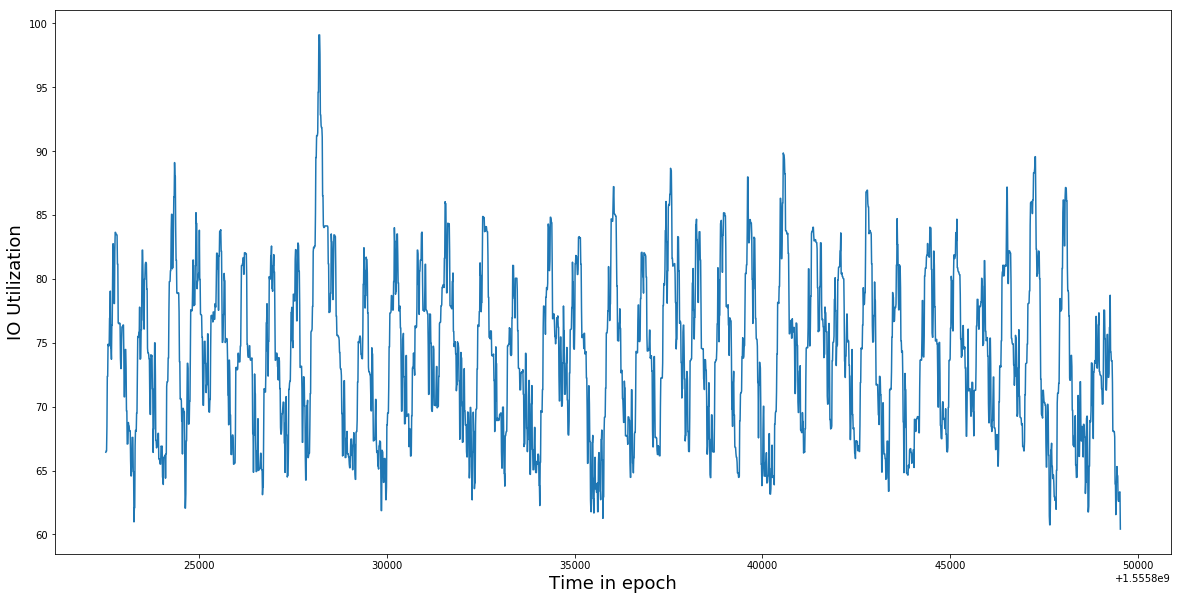

In [29]:
dataframe1 = pd.read_csv('io-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# This computes the AIC values. Dont execute this if you don't want to compute AIC values. 
# Takes a long time ~1hr

import warnings
warnings.filterwarnings('ignore')
aicVal = []
for i in range(1, 20):
    try:
        model_fit = ExponentialSmoothing(y1, seasonal_periods=i, trend='add', 
                                         seasonal='add').fit(use_boxcox=True)
        aicVal.append((i, model_fit.aic))
    except:
        continue

aicVal2 = aicVal;
aicVal2.sort(key=lambda x:x[1]);
aicVal2[0:10]

In [27]:
# Split into Train and Test samples

In [31]:
split_percent = 0.8448
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

420
2281


In [32]:
predictions = []
# for i in range(0, forecast_time, 6):
Y_Train = y1[0:0+train_samples]
model_fit = ExponentialSmoothing(Y_Train, seasonal_periods=50, seasonal='additive').fit(use_boxcox=True)
predictions.append(model_fit.forecast(420).values)

In [33]:
predictions = predictions[0].reshape(predictions[0].size, 1)

In [34]:
Pred = []
for i in range(5, forecast_time, 6):
    Pred.append(predictions[i])

In [35]:
X_Test = []
Y_Test = []
for i in range(6, forecast_time, 6):
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])

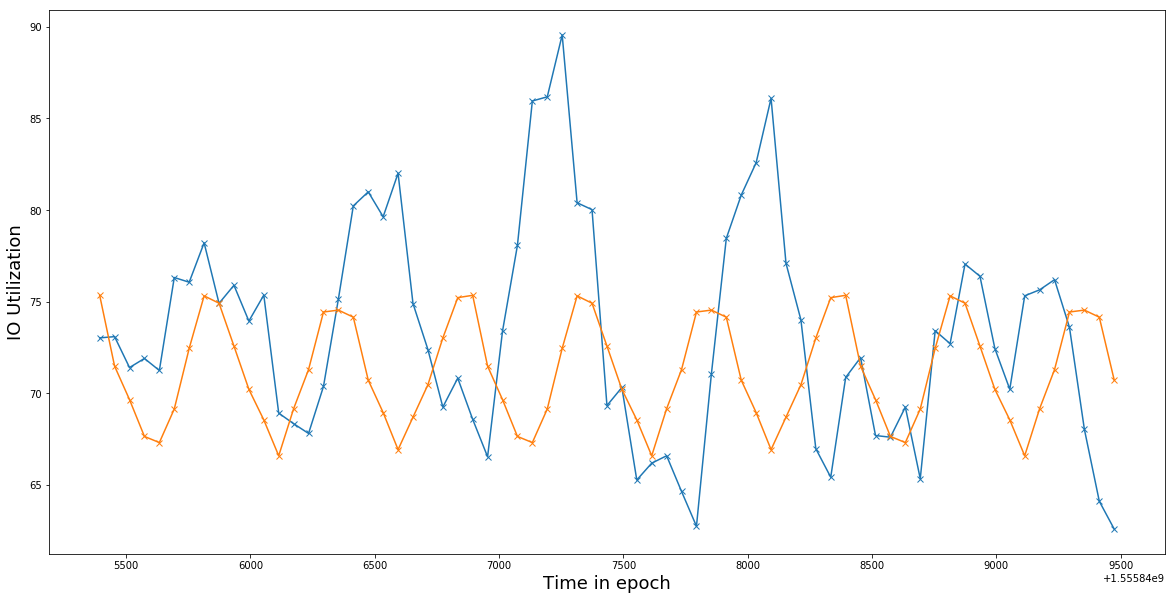

In [36]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, Pred[0:-1], {'marker': 'x'})

In [37]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [38]:
mean_absolute_percentage_error(Y_Test, Pred[0:-1])

7.247386012105536

In [39]:
for i in range(0,70):
    print(Pred[i][0])

75.3474905433145
71.48059183388708
69.65653435910397
67.64770236941754
67.31258192908618
69.14532533541379
72.45502663282163
75.31673791851304
74.91629027512973
72.57822655639734
70.21886361889075
68.54985221837059
66.59267158129529
69.16199927368902
71.29599546079598
74.43618162112682
74.54083725056971
74.15440899201721
70.72037804590423
68.94912253615608
66.92721283333445
68.69966955784002
70.46748239811579
73.01891422642706
75.21996873982552
75.3474905433145
71.48059183388708
69.65653435910397
67.64770236941754
67.31258192908618
69.14532533541379
72.45502663282163
75.31673791851304
74.91629027512973
72.57822655639734
70.21886361889075
68.54985221837059
66.59267158129529
69.16199927368902
71.29599546079598
74.43618162112682
74.54083725056971
74.15440899201721
70.72037804590423
68.94912253615608
66.92721283333445
68.69966955784002
70.46748239811579
73.01891422642706
75.21996873982552
75.3474905433145
71.48059183388708
69.65653435910397
67.64770236941754
67.31258192908618
69.1453253354

# CPU

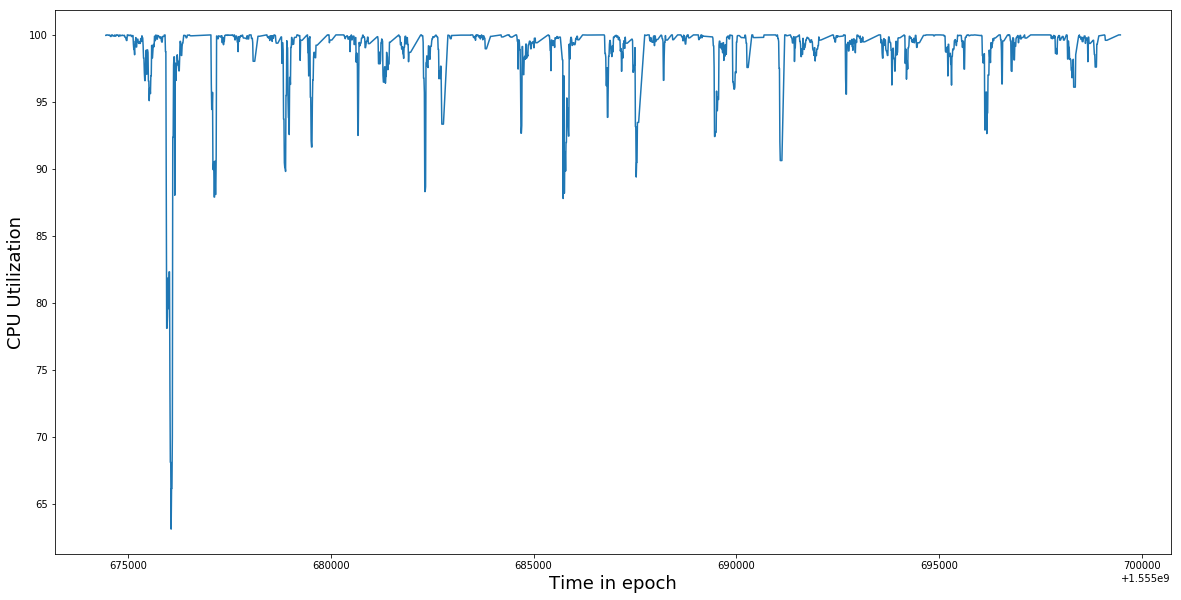

In [40]:
dataframe1 = pd.read_csv('cpu-util-new.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [41]:
split_percent = 0.80
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

347
1385


In [42]:
predictions = []
# for i in range(0, forecast_time, 6):
Y_Train = y1[0:0+train_samples]
model_fit = ExponentialSmoothing(Y_Train, seasonal_periods=60, seasonal='add').fit()
predictions.append(model_fit.forecast(forecast_time).values)

In [43]:
predictions = predictions[0].reshape(predictions[0].size, 1)
Pred = []
for i in range(5, forecast_time, 6):
    Pred.append(predictions[i])

In [44]:
X_Test = []
Y_Test = []
for i in range(6, forecast_time, 6):
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])

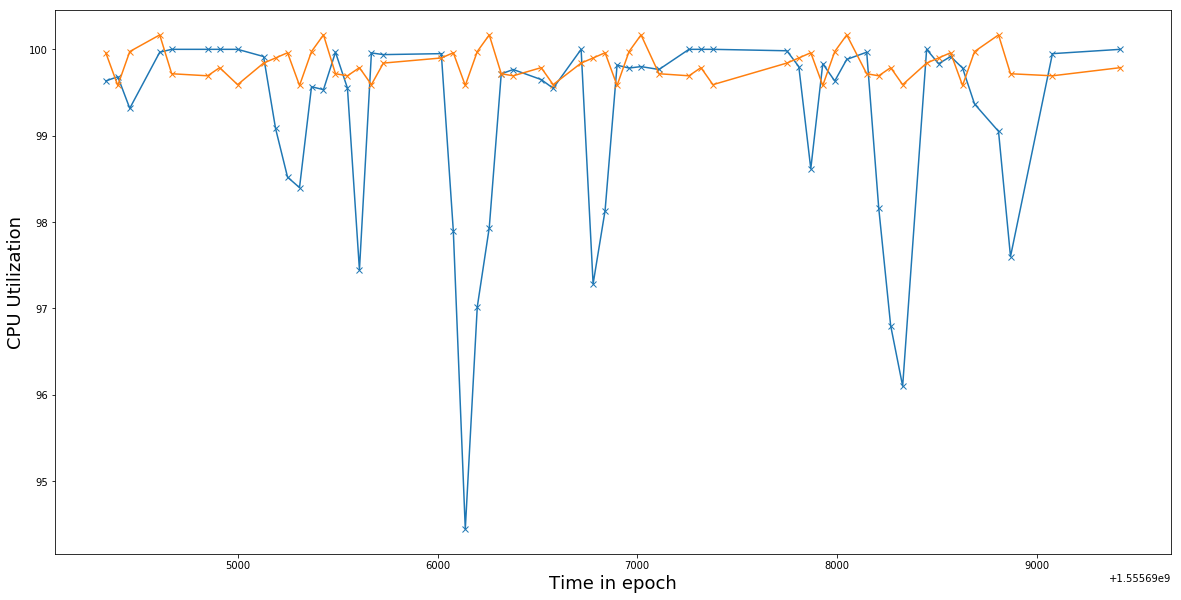

In [45]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, Pred, {'marker': 'x'})

In [46]:
mean_absolute_percentage_error(Y_Test, Pred)

0.7756408741552702

In [47]:
for i in range(0, len(Pred)):
    print(Pred[i][0])
    


99.96046986944386
99.58149175247426
99.97461993628288
100.16701983788573
99.71727264397343
99.69355468155686
99.78784507767655
99.59099112072684
99.8407923409548
99.89988653819962
99.96046986944386
99.58149175247426
99.97461993628288
100.16701983788573
99.71727264397343
99.69355468155686
99.78784507767655
99.59099112072684
99.8407923409548
99.89988653819962
99.96046986944386
99.58149175247426
99.97461993628288
100.16701983788573
99.71727264397343
99.69355468155686
99.78784507767655
99.59099112072684
99.8407923409548
99.89988653819962
99.96046986944386
99.58149175247426
99.97461993628288
100.16701983788573
99.71727264397343
99.69355468155686
99.78784507767655
99.59099112072684
99.8407923409548
99.89988653819962
99.96046986944386
99.58149175247426
99.97461993628288
100.16701983788573
99.71727264397343
99.69355468155686
99.78784507767655
99.59099112072684
99.8407923409548
99.89988653819962
99.96046986944386
99.58149175247426
99.97461993628288
100.16701983788573
99.71727264397343
99.693554

# MEMORY

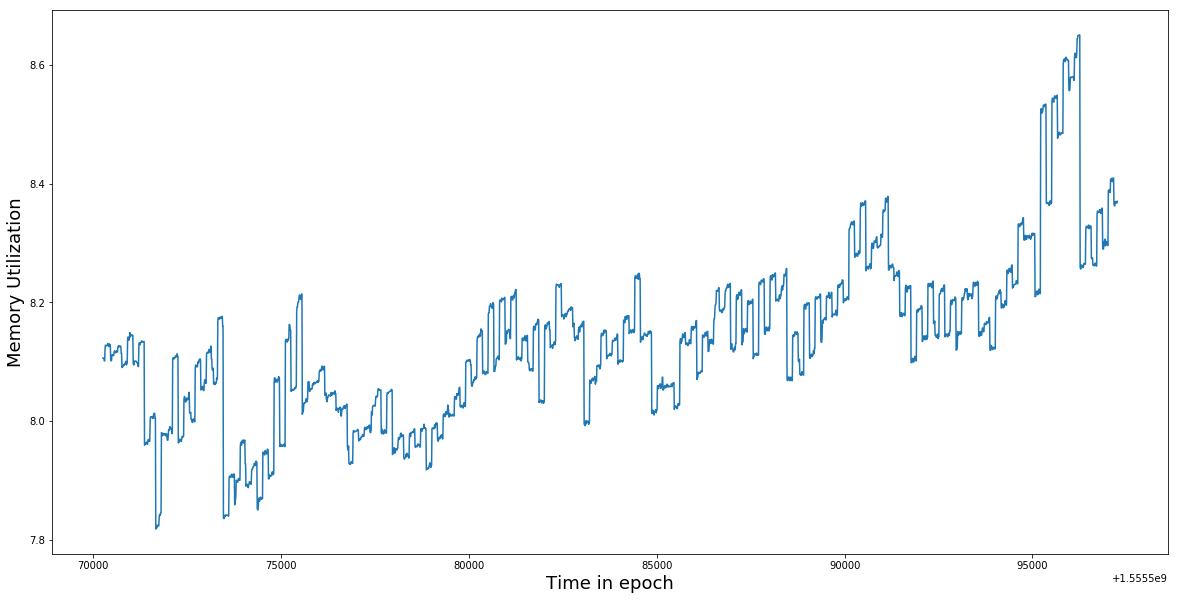

In [48]:
dataframe1 = pd.read_csv('mem-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('Memory Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [49]:
split_percent = 0.80
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

541
2160


In [50]:
predictions = []
# for i in range(0, forecast_time, 6):
Y_Train = y1[0:0+train_samples]
model_fit = ExponentialSmoothing(Y_Train, seasonal='multiplicative', 
                                 seasonal_periods=60).fit()
predictions.append(model_fit.forecast(forecast_time).values)

In [51]:
predictions = predictions[0].reshape(predictions[0].size, 1)
Pred = []
for i in range(5, forecast_time, 6):
    Pred.append(predictions[i])

In [52]:
X_Test = []
Y_Test = []
for i in range(6, forecast_time, 6):
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])

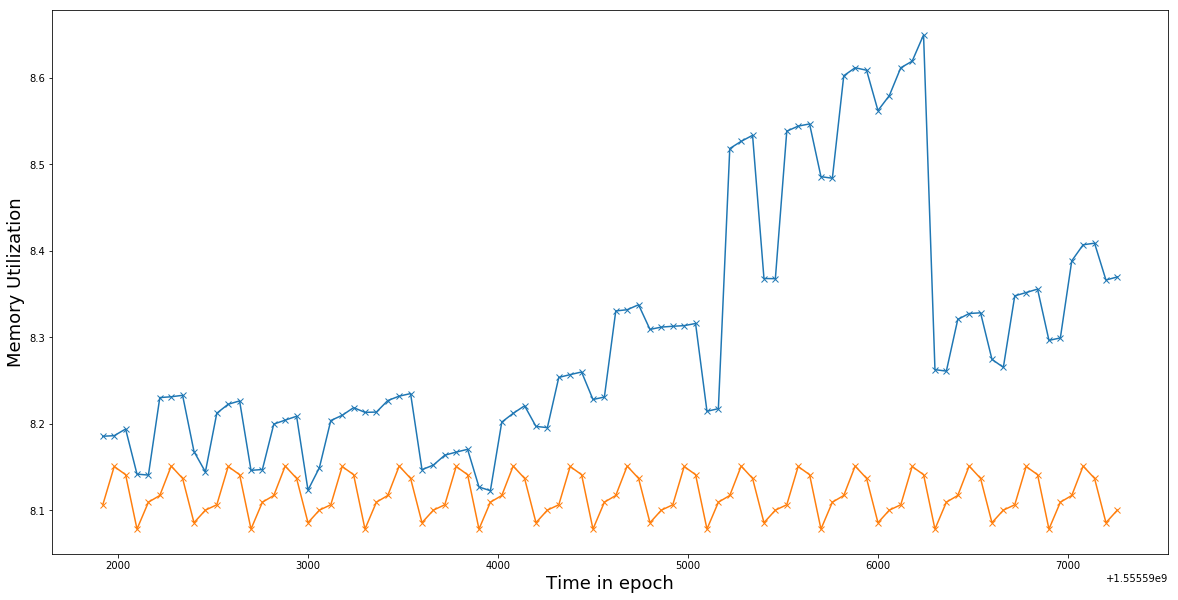

In [53]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('Memory Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, Pred, {'marker': 'x'})

In [54]:
mean_absolute_percentage_error(Y_Test, Pred)

2.1954423296997776

In [55]:
len(X_Test)

90

In [115]:
len(Y_Test)

90

In [116]:
len(Pred)

90

In [26]:
X_Test;
